# Prepare data for training and evaluation using `eo-learn`

This notebook sets up `eo-learn` workflows to pre-process data in `EOPatch` format. This allows to quickly evaluate different pre-processing methods.

workflows include:

 * morphological operators on cloud probabilities/masks;
 * computation of vegetation indices (e.g. NDVI, TasselatedCAP)
 * interpolation/compositing for filling masked values;
 * sampling to retrieve only pixels used for training/testing.

Authors: Gustave, Deo, Christian

In [1]:
!pip install gdal rasterio shapely fiona eo-learn radiant-mlhub imagecodecs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
# Required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

import datetime
import tifffile as tiff
import rasterio as rio # Reading and writing raster data
import glob
import shutil
import imagecodecs

from tqdm.auto import tqdm

from radiant_mlhub import Dataset as Ds
from radiant_mlhub import Collection

from eolearn.core import EOPatch, AddFeatureTask, FeatureType, FeatureTypeSet, OverwritePermission, LoadTask # , LinearWorkflow
from eolearn.core import MapFeatureTask, ZipFeatureTask, EOTask
from eolearn.features import SimpleFilterTask, ValueFilloutTask, NormalizedDifferenceIndexTask # , LinearInterpolation

from  eolearn.features import LinearInterpolationTask as LinearInterpolation
from skimage.morphology import disk, binary_dilation, binary_erosion

In [10]:
# Login to RadiantML
!mlhub configure

API Key: c9156069855719f500599217306051036510fefbf2027842067a71dbe1e4f7d2
Overwrite existing API Key (****e4f7d2) [y/N]: y
Wrote profile to /root/.mlhub/profiles


In [5]:

# 

In [3]:
ds = Ds.fetch('umd_mali_crop_type')

for c in ds.collections:
    print(c.id)

umd_mali_crop_type_labels
umd_mali_crop_type_source


In [2]:
ROOT_PATH = "/content/data"

In [12]:
# Download the data
for c in ds.collections:
    print(c.id)
    collection = Collection.fetch(c.id)
    collection.download(ROOT_PATH)

umd_mali_crop_type_labels


  0%|          | 0/0.2 [00:00<?, ?M/s]

umd_mali_crop_type_source


  0%|          | 0/473.9 [00:00<?, ?M/s]

In [3]:
# location of directory to which data has been downloaded
ROOT_DATA_DIR = f'{ROOT_PATH}/unzip'

In [14]:
# Unzip dataset
shutil.unpack_archive(f"{ROOT_PATH}/umd_mali_crop_type_labels.tar.gz", f"{ROOT_DATA_DIR}")
shutil.unpack_archive(f"{ROOT_PATH}/umd_mali_crop_type_source.tar.gz", f"{ROOT_DATA_DIR}")

In [4]:
bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'CLM']

In [5]:
def load_file(img_path):
    """Takes a PosixPath object or string filepath
    and returns np array"""

    return tiff.imread(str(img_path))



def load_image(field, date):
    source='umd_mali_crop_type_source/umd_mali_crop_type_source_'
    img = list()
    for band in bands:
        file_name = f"{ROOT_DATA_DIR}/{source}{int(field)}_{date}/{band}.tif"
        img.append(load_file(file_name))
    return np.dstack(img)

def load_timeseries(field, dates):
    tstack = list()
    with tqdm(dates, total=len(dates), desc=f"reading images for field {field}") as pbar:
        for date in pbar:
            tstack.append(load_image(field, date.strftime("%Y_%m_%d")))
    return np.stack(tstack) 

def load_label(field):
    label='umd_mali_crop_type_labels/umd_mali_crop_type_labels_'
    return tiff.imread(f'{ROOT_DATA_DIR}/{label}{field}/labels.tif')



In [6]:
# Get a list of dates that an observation from Sentinel-2 is provided for from the currently downloaded imagery
field_dates = {}
for f in glob.glob(f'{ROOT_DATA_DIR}/**/*.tif', recursive=True):
    
    if len(f.split('_')) != len(f'{ROOT_DATA_DIR}'.split('_'))+12:
        continue
    field_id = f.split('_')[-4]
    
    date = datetime.datetime.strptime(f.split('/')[-2][-10:], '%Y_%m_%d')
    if field_dates.get(field_id, None) is None:
        field_dates[field_id] = []
    field_dates[field_id].append(date)

for field_id, dates in field_dates.items():
    field_dates[field_id] = list(set(field_dates[field_id]))


In [7]:
# All fields have the same timestamps
for field in field_dates.keys():
    assert sorted(field_dates['10']) == sorted(field_dates[field])


In [8]:
# Load a field 

selected_field = list(field_dates.keys())[2]
dates = sorted(field_dates[selected_field])
timeseries = load_timeseries(selected_field, dates)

print(f'Field {selected_field} imagery has shape [n_times, height, width, bands]: {timeseries.shape}')


reading images for field 14:   0%|          | 0/41 [00:00<?, ?it/s]

Field 14 imagery has shape [n_times, height, width, bands]: (41, 256, 256, 13)


In [9]:
def save_as_eopatch(data, label, dates, folder):
    """
    Creates an EOPatch and adds data:
    * S2 L2A bands will be stored in DATA feature under name `S2-BANDS-L2A`
    * sen2cor cloud probabilities will be stored in DATA feature under name `CLOUD_PROB`
    * labels will be stored in MASK_TIMELESS under name `CROP_ID`
    * field ids  will be stored in MASK_TIMELESS under name `FIELD_ID`
    * dates of observations will be added to timestamps
    
    EOPatch is saved to specified folder.
    """
    
    eopatch = EOPatch()
  
    eopatch[FeatureType.DATA]['S2-BANDS-L2A'] = np.where(np.isfinite(data[..., :12]), data[..., :12], np.nan)  # Replace invalid values with NaN
    eopatch[FeatureType.MASK_TIMELESS]['CROP_ID'] =np.where(np.isfinite(label), label, np.nan)[..., np.newaxis].astype(int)  # Replace invalid values with NaN
    eopatch.timestamp = dates

    eopatch.save(folder, overwrite_permission=OverwritePermission.OVERWRITE_FEATURES)

    return eopatch

In [10]:
eopatch_dir = f'{ROOT_DATA_DIR}/eopatches'

for field in sorted(field_dates.keys()):
    dates = sorted(field_dates[field])
    timeseries = load_timeseries(field, dates)
    eop_folder = f'{eopatch_dir}/eopatch-{field}'
    data = timeseries
    labels = load_label(field)
    save_as_eopatch(data, labels, dates, eop_folder)


reading images for field 1:   0%|          | 0/41 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/eolearn/core/eodata.py:294: EODeprecationWarning: Initializing an EOPatch without providing a BBox will no longer be possible in the future. EOPatches represent geolocated data and so any EOPatch without a BBox is ill-formed. Consider using a different data structure for non-geolocated data.
  value = self._parse_feature_type_value(feature_type, value)
<attrs generated init eolearn.core.eodata.EOPatch>:51: EODeprecationWarning: Initializing an EOPatch without providing a BBox will no longer be possible in the future. EOPatches represent geolocated data and so any EOPatch without a BBox is ill-formed. Consider using a different data structure for non-geolocated data.
  self.__attrs_post_init__()
/usr/local/lib/python3.9/dist-packages/eolearn/core/eodata.py:296: EODeprecationWarning: The attribute `timestamp` is deprecated, use `timestamps` instead.
  super().__setattr__(key, value)


reading images for field 10:   0%|          | 0/41 [00:00<?, ?it/s]

reading images for field 11:   0%|          | 0/41 [00:00<?, ?it/s]

reading images for field 12:   0%|          | 0/41 [00:00<?, ?it/s]

reading images for field 13:   0%|          | 0/41 [00:00<?, ?it/s]

reading images for field 14:   0%|          | 0/41 [00:00<?, ?it/s]

reading images for field 15:   0%|          | 0/41 [00:00<?, ?it/s]

reading images for field 16:   0%|          | 0/41 [00:00<?, ?it/s]

reading images for field 17:   0%|          | 0/41 [00:00<?, ?it/s]

reading images for field 18:   0%|          | 0/41 [00:00<?, ?it/s]

reading images for field 19:   0%|          | 0/41 [00:00<?, ?it/s]

reading images for field 2:   0%|          | 0/41 [00:00<?, ?it/s]

reading images for field 20:   0%|          | 0/41 [00:00<?, ?it/s]

reading images for field 21:   0%|          | 0/41 [00:00<?, ?it/s]

reading images for field 22:   0%|          | 0/41 [00:00<?, ?it/s]

reading images for field 23:   0%|          | 0/41 [00:00<?, ?it/s]

reading images for field 24:   0%|          | 0/41 [00:00<?, ?it/s]

reading images for field 25:   0%|          | 0/41 [00:00<?, ?it/s]

reading images for field 26:   0%|          | 0/41 [00:00<?, ?it/s]

reading images for field 27:   0%|          | 0/41 [00:00<?, ?it/s]

reading images for field 28:   0%|          | 0/41 [00:00<?, ?it/s]

reading images for field 29:   0%|          | 0/41 [00:00<?, ?it/s]

reading images for field 3:   0%|          | 0/41 [00:00<?, ?it/s]

reading images for field 30:   0%|          | 0/41 [00:00<?, ?it/s]

reading images for field 31:   0%|          | 0/41 [00:00<?, ?it/s]

reading images for field 32:   0%|          | 0/41 [00:00<?, ?it/s]

reading images for field 33:   0%|          | 0/41 [00:00<?, ?it/s]

reading images for field 4:   0%|          | 0/41 [00:00<?, ?it/s]

reading images for field 5:   0%|          | 0/41 [00:00<?, ?it/s]

reading images for field 6:   0%|          | 0/41 [00:00<?, ?it/s]

reading images for field 7:   0%|          | 0/41 [00:00<?, ?it/s]

reading images for field 8:   0%|          | 0/41 [00:00<?, ?it/s]

reading images for field 9:   0%|          | 0/41 [00:00<?, ?it/s]

## Visualize a single EOPatch

In [11]:
eopatch_names = glob.glob(f'{eopatch_dir}/*')

In [12]:
eop_idx = 4
eop_name = eopatch_names[eop_idx].split('/')[-1]
eop = EOPatch.load(eopatch_names[eop_idx])

Text(0.5, 1.0, 'CROP_ID')

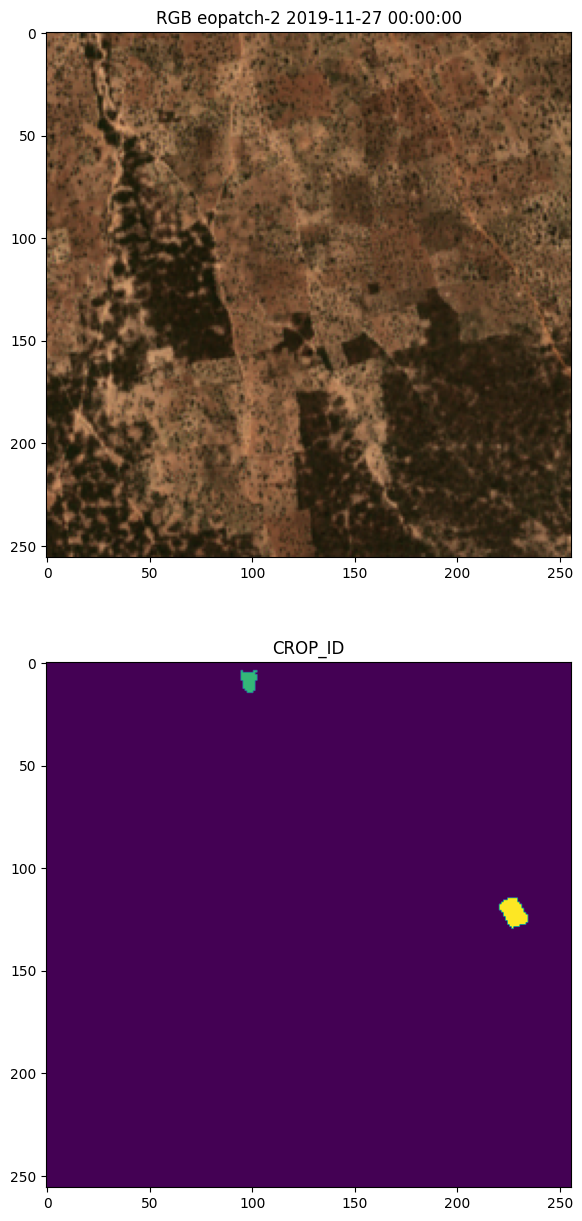

In [13]:
time_idx = 40
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,15))
axs=axs.flatten()
axs[0].imshow(np.moveaxis(eop.data['S2-BANDS-L2A'][time_idx,...,[3,2,1]]*0.009,0,-1))
axs[0].set_title(f'RGB {eop_name} {eop.timestamps[time_idx]}')
axs[1].imshow(eop.mask_timeless['CROP_ID'].squeeze())
axs[1].set_title(f'CROP_ID')


Initialise `EOTask`s that will be used in pre-processing workflow. 

The [`MapFeatureMask`](https://eo-learn.readthedocs.io/en/latest/eolearn.core.core_tasks.html#eolearn.core.core_tasks.MapFeatureTask) applies a given function and hyper-parameters to the input features, generating the output features.

In [18]:
# ndvi
ndvi_task = NormalizedDifferenceIndexTask((FeatureType.DATA, 'S2-BANDS-L2A'),
                                          (FeatureType.DATA, 'NDVI'), 
                                          [7,3])

# interpolation
lin_interp = LinearInterpolation((FeatureType.DATA, 'S2-BANDS-L2A'), 
                                #  mask_feature=(FeatureType.MASK, 'VALID_DATA'),
                                 copy_features=[(FeatureType.DATA, 'NDVI')], # comment this out if NDVI is not used
                                 resample_range=dates)

# if invalid data are at beginning or end of time-series, pad with nearest value
fillout = ValueFilloutTask((FeatureType.DATA, 'S2-BANDS-L2A'))

In [19]:
class ComposeTask(EOTask):
    """Composes several tasks together.
    """

    def __init__(self, tasks):
        self.tasks = tasks

    def execute(self, eopatch):
        for t in self.tasks:
            eopatch = t(eopatch)
        return eopatch

In [21]:
preprocess = ComposeTask([ndvi_task, lin_interp, fillout]) 

### processed data

In [24]:
eop_name = 'eopatch-11'
eop=EOPatch.load(f'{ROOT_DATA_DIR}/eopatches/{eop_name}')
eop_linear = preprocess(eop)

In [25]:
eop_linear

EOPatch(
  data={
    NDVI: numpy.ndarray(shape=(41, 256, 256, 1), dtype=float64)
    S2-BANDS-L2A: numpy.ndarray(shape=(41, 256, 256, 12), dtype=float64)
  }
  timestamps=[datetime.datetime(2019, 5, 1, 0, 0), ..., datetime.datetime(2019, 11, 27, 0, 0)], length=41
)

/usr/local/lib/python3.9/dist-packages/eolearn/core/eodata.py:325: EODeprecationWarning: The attribute `timestamp` is deprecated, use `timestamps` instead.
  value = super().__getattribute__(key)


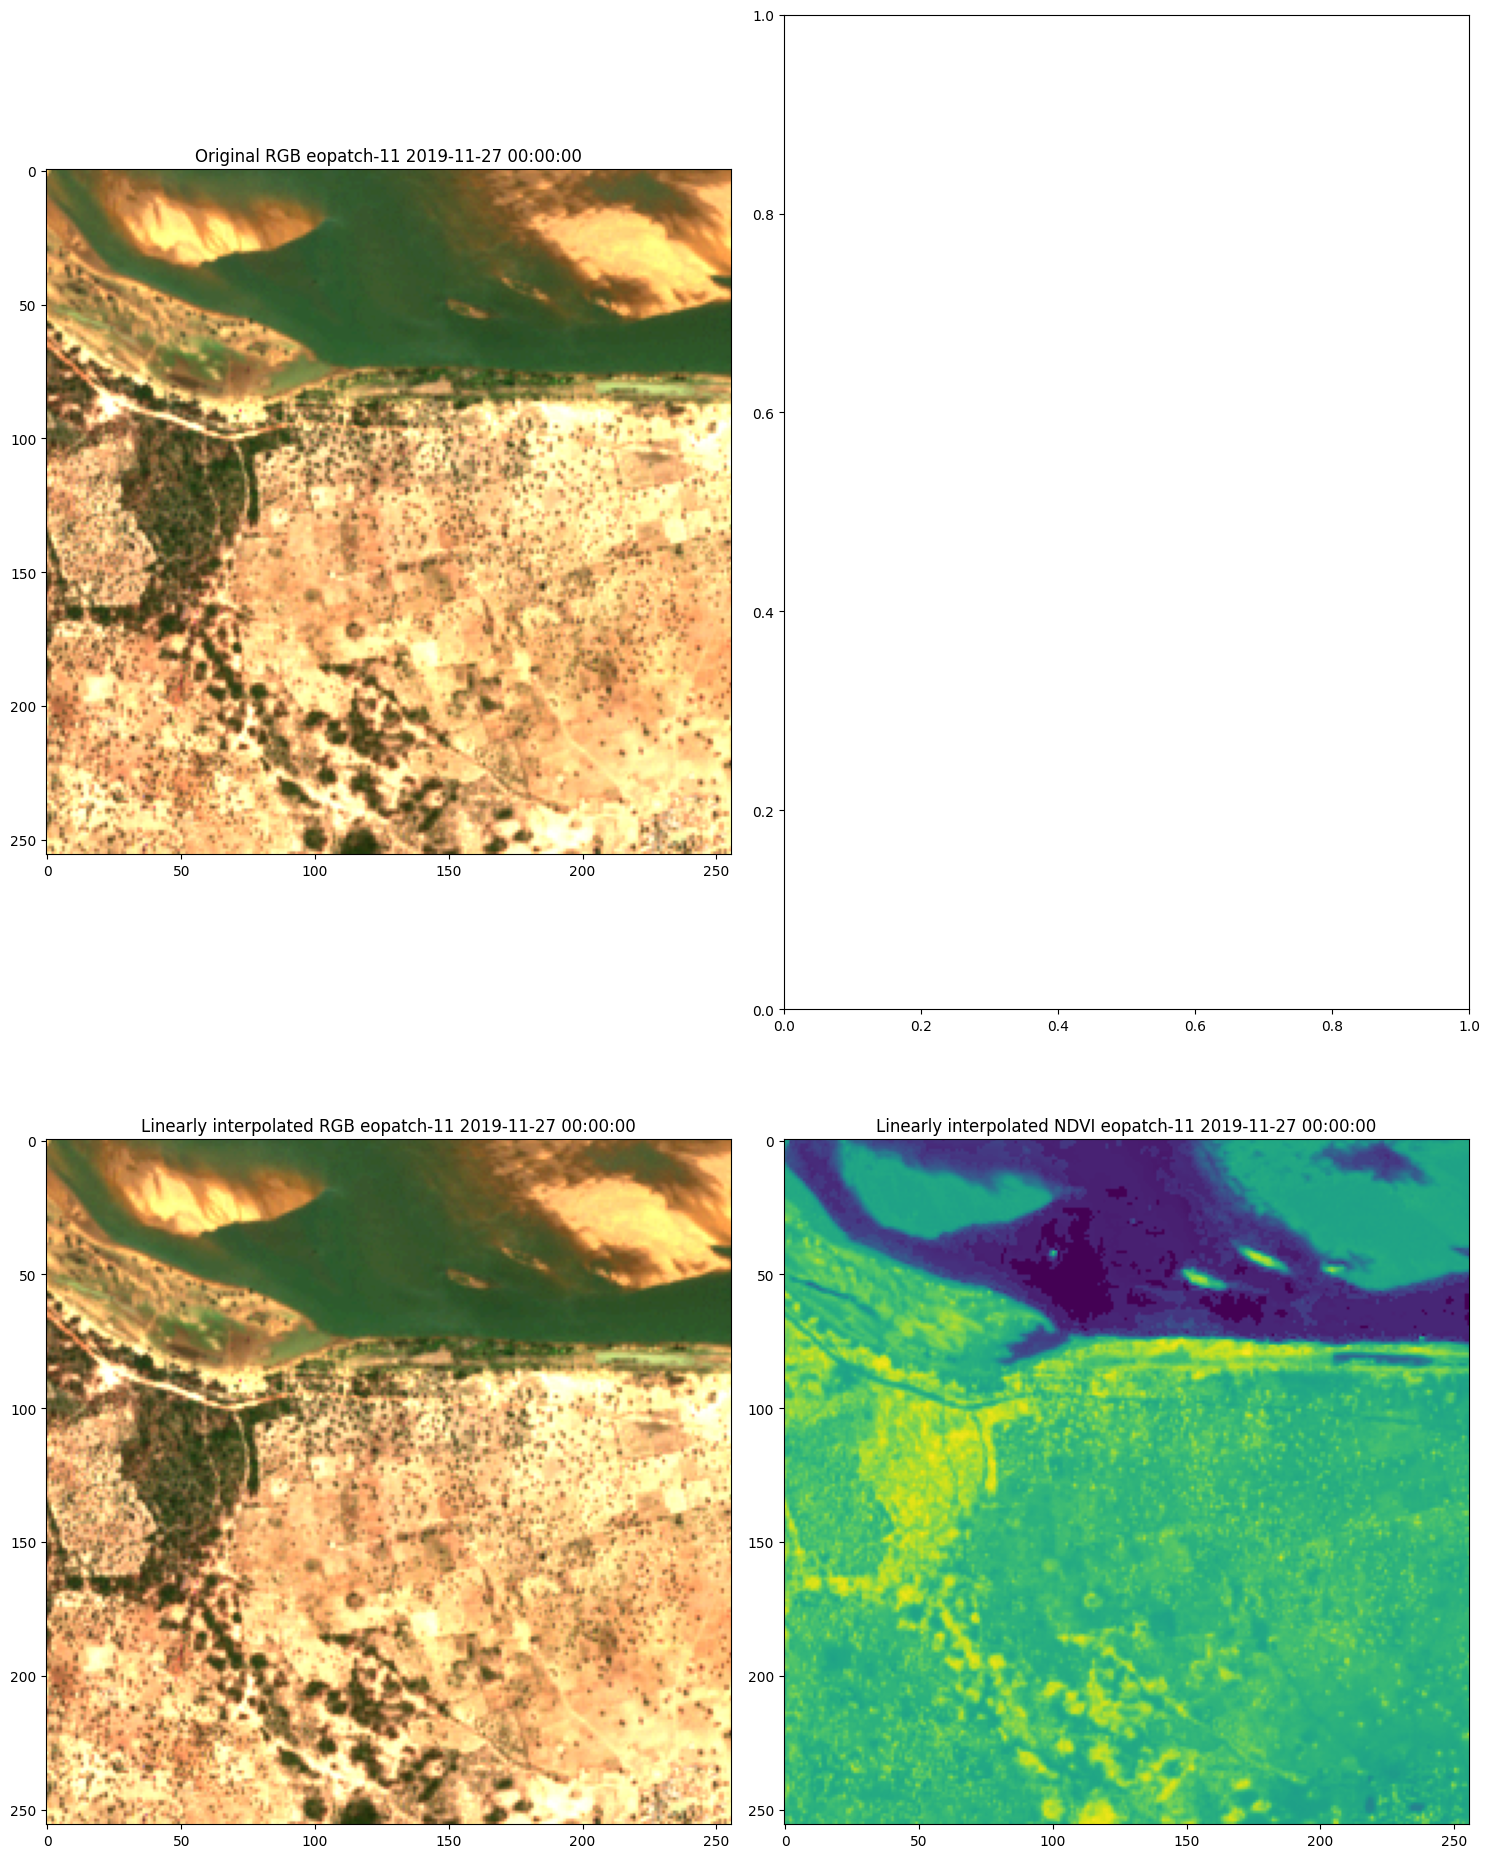

In [26]:
time_idx = -1

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 20))

axs[0,0].imshow(np.moveaxis(eop.data['S2-BANDS-L2A'][time_idx,...,[3,2,1]],0,-1)*0.02)
axs[0,0].set_title(f'Original RGB {eop_name} {eop.timestamp[time_idx]}')
axs[1,0].imshow(np.moveaxis(eop_linear.data['S2-BANDS-L2A'][time_idx,...,[3,2,1]],0,-1)*0.02)
axs[1,0].set_title(f'Linearly interpolated RGB {eop_name} {eop.timestamp[time_idx]}')
axs[1,1].imshow(eop_linear.data['NDVI'][time_idx].squeeze())
axs[1,1].set_title(f'Linearly interpolated NDVI {eop_name} {eop.timestamp[time_idx]}')

plt.tight_layout()

### Merge all sampled pixels to numpy arrays

In [30]:
random_state = 42
np.random.seed(random_state)
random.seed(random_state)
# Get list of EOPatch paths
eopatch_paths = random.sample(glob.glob(f'{ROOT_DATA_DIR}/eopatches/*'), int(len(glob.glob(f'{ROOT_DATA_DIR}/eopatches/*'))*0.6))


# Calculate the number of EOPatches to select for training
num_train = int(0.7 * len(eopatch_paths))

# Randomly select 70% of EOPatches for training
eopatch_paths_train = random.sample(eopatch_paths, num_train)

# Remaining EOPatches are used for testing
eopatch_paths_test = list(set(eopatch_paths) - set(eopatch_paths_train))


In [33]:
X_train = []
y_train = []
pbar = tqdm(total=len(eopatch_paths_train))
# Loop through the randomly selected EOPatch paths for training
for eopatch_path in eopatch_paths_train:
    # Load the EOPatch
    eopatch = EOPatch.load(eopatch_path)
    eop_proc =  preprocess(eop)
    # Extract the features and labels from the EOPatch
    data = np.moveaxis(eop_proc.data['S2-BANDS-L2A'].squeeze(),1,0)
    ndvi = np.moveaxis(eop_proc.data['NDVI'].squeeze(),1,0)
    labels = eopatch.mask_timeless['CROP_ID'].squeeze()
    
    # Concatenate data and ndvi along the last axis
    features = np.concatenate([data, ndvi[..., np.newaxis]], axis=-1)
    features_flattened = features#.reshape((-1, features.shape[-1]))
    labels_flattened = labels#.flatten()
    # Append the flattened features and labels to the training data lists
    X_train.append(features_flattened)
    y_train.append(labels_flattened)
    pbar.update()
# Concatenate the training data lists to create X_train and y_train arrays
X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)


  0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/eolearn/core/eodata.py:294: EODeprecationWarning: Initializing an EOPatch without providing a BBox will no longer be possible in the future. EOPatches represent geolocated data and so any EOPatch without a BBox is ill-formed. Consider using a different data structure for non-geolocated data.
  value = self._parse_feature_type_value(feature_type, value)
<attrs generated init eolearn.core.eodata.EOPatch>:51: EODeprecationWarning: Initializing an EOPatch without providing a BBox will no longer be possible in the future. EOPatches represent geolocated data and so any EOPatch without a BBox is ill-formed. Consider using a different data structure for non-geolocated data.
  self.__attrs_post_init__()


In [34]:
X_train.shape, y_train.shape

((3328, 41, 256, 13), (3328, 256))

In [35]:
X_train = X_train.reshape(X_train.shape[0]*X_train.shape[2], X_train.shape[1]*X_train.shape[3])

y_train = y_train.reshape(y_train.shape[0]*y_train.shape[1],)
X_train.shape, y_train.shape

((851968, 533), (851968,))

In [36]:
X_test = []
y_test = []
pbar = tqdm(total=len(eopatch_paths_test))
# Loop through the randomly selected EOPatch paths for training
for eopatch_path in eopatch_paths_test:
    # Load the EOPatch
    eopatch = EOPatch.load(eopatch_path, lazy_loading=True)
    eop_proc =  preprocess(eopatch)
    # Extract the features and labels from the EOPatch
    data = np.moveaxis(eop_proc.data['S2-BANDS-L2A'].squeeze(),1,0)
    ndvi = np.moveaxis(eop_proc.data['NDVI'].squeeze(),1,0)
    labels = eopatch.mask_timeless['CROP_ID'].squeeze()
    
    # Concatenate data and ndvi along the last axis
    features = np.concatenate([data, ndvi[..., np.newaxis]], axis=-1)
    feature_flatten = features#.reshape((-1, features.shape[-1]))
    label_flatten = labels#.reshape((-1,))
    # Append the flattened features and labels to the training data lists
    X_test.append(feature_flatten)
    y_test.append(label_flatten)
    pbar.update()
# Concatenate the training data lists to create X_train and y_train arrays
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)




  0%|          | 0/6 [00:00<?, ?it/s]

In [37]:
X_test.shape, y_test.shape

((1536, 41, 256, 13), (1536, 256))

In [38]:
X_test = X_test.reshape(X_test.shape[0]*X_test.shape[2], X_test.shape[1]*X_test.shape[3])

y_test = y_test.reshape(y_test.shape[0]*y_test.shape[1],)
X_test.shape, y_test.shape

((393216, 533), (393216,))

# Train a model

Split training data into 90/10 

#### Train RF model on pixels and get scores on cross-validation split

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.utils import shuffle

In [46]:
rf = RandomForestClassifier(n_estimators=5, random_state=random_state)

rf.fit(X_train, y_train)



RandomForestClassifier(n_estimators=5, random_state=42)

In [47]:
rf_preds = rf.predict(X_test)

In [48]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
unq_lbls = np.unique(y_train)

f1_scores = metrics.f1_score(y_test, rf_preds, labels=unq_lbls, average=None)
recall = metrics.recall_score(y_test, rf_preds, labels=unq_lbls, average=None)
precision = metrics.precision_score(y_test, rf_preds, labels=unq_lbls, average=None)
    
for idx, class_id in enumerate(unq_lbls):
    print(f'        * class {class_id:5d} = {f1_scores[idx]*100:2.1f} | {recall[idx]*100:2.1f} | {precision[idx]*100:2.1f} | {np.count_nonzero(y_test==class_id):8d}')

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


        * class     0 = 99.9 | 100.0 | 99.8 |   392464
        * class     1 = 0.0 | 0.0 | 0.0 |      239
        * class     2 = 0.0 | 0.0 | 0.0 |      215
        * class     3 = 0.0 | 0.0 | 0.0 |      298
        * class     4 = 0.0 | 0.0 | 0.0 |        0


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
